In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
#import gcsfs

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/var/folders/k1/5_y16ccj4zv7lcjp767yd1b80000gn/T/ipykernel_28919/1343192083.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/hrh/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
cmip6_gmst_path  = '/users/hrh/Desktop/TwoMoments21/cvals/cmip6_gmst_ssp370.zarr'

In [3]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [4]:
[eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]

['ssp585',
 'ssp245',
 'ssp370SST-lowCH4',
 'ssp370-lowNTCF',
 'ssp370SST-lowNTCF',
 'ssp370SST-ssp126Lu',
 'ssp370SST',
 'ssp370pdSST',
 'ssp119',
 'ssp370',
 'esm-ssp585-ssp126Lu',
 'ssp126-ssp370Lu',
 'ssp370-ssp126Lu',
 'ssp126',
 'esm-ssp585',
 'ssp245-GHG',
 'ssp245-nat',
 'ssp460',
 'ssp434',
 'ssp534-over',
 'ssp245-stratO3',
 'ssp245-aer',
 'ssp245-cov-modgreen',
 'ssp245-cov-fossil',
 'ssp245-cov-strgreen',
 'ssp245-covid',
 'ssp585-bgc']

In [31]:
[eid for eid in col.df['experiment_id'].unique() if 'hist' in eid]

['hist-1950',
 'historical',
 'esm-hist',
 'hist-piAer',
 'histSST-1950HC',
 'hist-1950HC',
 'histSST',
 'piClim-histall',
 'hist-piNTCF',
 'histSST-piNTCF',
 'histSST-piO3',
 'hist-aer',
 'histSST-piAer',
 'hist-nat',
 'hist-GHG',
 'piClim-histnat',
 'piClim-histghg',
 'histSST-piCH4',
 'amip-hist',
 'piClim-histaer',
 'hist-noLu',
 'land-hist-altStartYear',
 'land-hist',
 'hist-stratO3',
 'historical-cmip5',
 'hist-bgc',
 'hist-sol',
 'hist-CO2',
 'hist-volc',
 'hist-totalO3',
 'hist-nat-cmip5',
 'hist-aer-cmip5',
 'hist-GHG-cmip5',
 'hist-resIPO',
 'historical-ext']

In [32]:
# there is currently a significant amount of data for these runs
expts = ['ssp370','historical']

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['tas'],
    member_id = 'r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,2,1,1
AWI-CM-1-1-MR,2,1,1
BCC-CSM2-MR,2,1,1
BCC-ESM1,2,1,1
CAMS-CSM1-0,2,1,1
CAS-ESM2-0,2,1,1
CESM2-WACCM,2,1,1
CMCC-CM2-SR5,2,1,1
CMCC-ESM2,2,1,1


In [33]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [34]:
dsets_ = dask.compute(dict(dsets))[0]

In [35]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [36]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].pipe(global_mean)
                             .swap_dims({'time': 'year'})
                             .drop('time')
                             .coarsen(year=12).mean()
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',
                                 dim=expt_da)

  0%|          | 0/31 [00:00<?, ?it/s]

In [37]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

[########################################] | 100% Completed | 287.49 s


In [46]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds

<xarray.Dataset>
Dimensions:        (year: 251, experiment_id: 2, source_id: 31)
Coordinates:
  * year           (year) float64 1.85e+03 1.851e+03 ... 2.099e+03 2.1e+03
  * experiment_id  (experiment_id) <U10 'ssp370' 'historical'
  * source_id      (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'TaiESM1'
Data variables:
    tas            (source_id, experiment_id, year) float64 nan nan ... nan nan

In [39]:
# gmst     = big_ds.tas
# gmst     = gmst.dropna(dim='source_id')
# gmst
# ######### Save gmst #######
# #gmst.to_dataset().to_zarr(cmip6_gmst_path)
# ###########################
# gmst      = xr.open_zarr(cmip6_gmst_path)
# gmst      = gmst.tas

In [13]:
# gmst_eoc = gmst.sel(year=2100)
# gmst_eoc

<xarray.DataArray 'tas' (source_id: 27, experiment_id: 1)>
dask.array<getitem, shape=(27, 1), dtype=float64, chunksize=(27, 1), chunktype=numpy.ndarray>
Coordinates:
  * experiment_id  (experiment_id) <U6 'ssp370'
  * source_id      (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'TaiESM1'
    year           int64 2100

In [51]:
#df_all = big_ds.sel(year=slice(1900, 2100)).to_dataframe().reset_index()
# big_ds = big_ds.dropna(dim='source_id')
df_all = big_ds.to_dataframe().reset_index()
df_all_eoc = big_ds.sel(experiment_id='ssp370').sel(year= slice(2071,2100)).mean('year').to_dataframe().reset_index()
df_all_pi = big_ds.sel(experiment_id='historical').sel(year= slice(1851,1879)).mean('year').to_dataframe().reset_index()
df_all_eoc

,source_id,experiment_id,tas
0,ACCESS-CM2,ssp370,291.125489
1,AWI-CM-1-1-MR,ssp370,290.670174
2,BCC-CSM2-MR,ssp370,291.349218
3,BCC-ESM1,ssp370,NaN
4,CAMS-CSM1-0,ssp370,289.583286
5,CAS-ESM2-0,ssp370,290.734981
6,CESM2-WACCM,ssp370,290.986804
7,CMCC-CM2-SR5,ssp370,291.140840
8,CMCC-ESM2,ssp370,291.009029
9,CanESM5,ssp370,292.279338


In [53]:
df_all_pi

,source_id,experiment_id,tas
0,ACCESS-CM2,historical,286.946658
1,AWI-CM-1-1-MR,historical,286.874536
2,BCC-CSM2-MR,historical,287.873075
3,BCC-ESM1,historical,288.084853
4,CAMS-CSM1-0,historical,287.037847
5,CAS-ESM2-0,historical,287.216907
6,CESM2-WACCM,historical,286.918251
7,CMCC-CM2-SR5,historical,287.285249
8,CMCC-ESM2,historical,287.223052
9,CanESM5,historical,286.689331


In [57]:
big_ds_eoc_ano = big_ds.sel(experiment_id='ssp370').sel(year= slice(2071,2100)).mean('year') - big_ds.sel(experiment_id='historical').sel(year= slice(1851,1879)).mean('year')
df_eoc_ano     = big_ds_eoc_ano.dropna('source_id').to_dataframe().reset_index()
df_eoc_ano

,source_id,tas
0,ACCESS-CM2,4.178831
1,AWI-CM-1-1-MR,3.795637
2,BCC-CSM2-MR,3.476143
3,CAMS-CSM1-0,2.545439
4,CAS-ESM2-0,3.518074
5,CESM2-WACCM,4.068553
6,CMCC-CM2-SR5,3.855592
7,CMCC-ESM2,3.785977
8,CanESM5,5.590007
9,EC-Earth3,4.060117


In [62]:
df_eoc_ano['tas'].mean()

3.663304384397669

In [63]:
df_eoc_ano['tas'].std()

0.7119537878523803

In [28]:
df_all_pi

,experiment_id,source_id,tas
0,ssp370,ACCESS-CM2,NaN
1,ssp370,AWI-CM-1-1-MR,NaN
2,ssp370,BCC-CSM2-MR,NaN
3,ssp370,CAS-ESM2-0,NaN
4,ssp370,CESM2-WACCM,NaN
5,ssp370,CMCC-CM2-SR5,NaN
6,ssp370,CMCC-ESM2,NaN
7,ssp370,CanESM5,NaN
8,ssp370,EC-Earth3,NaN
9,ssp370,EC-Earth3-AerChem,NaN


Text(0.5, 1.0, 'EOC, GMST anomaly from 27 CMIP6 models')

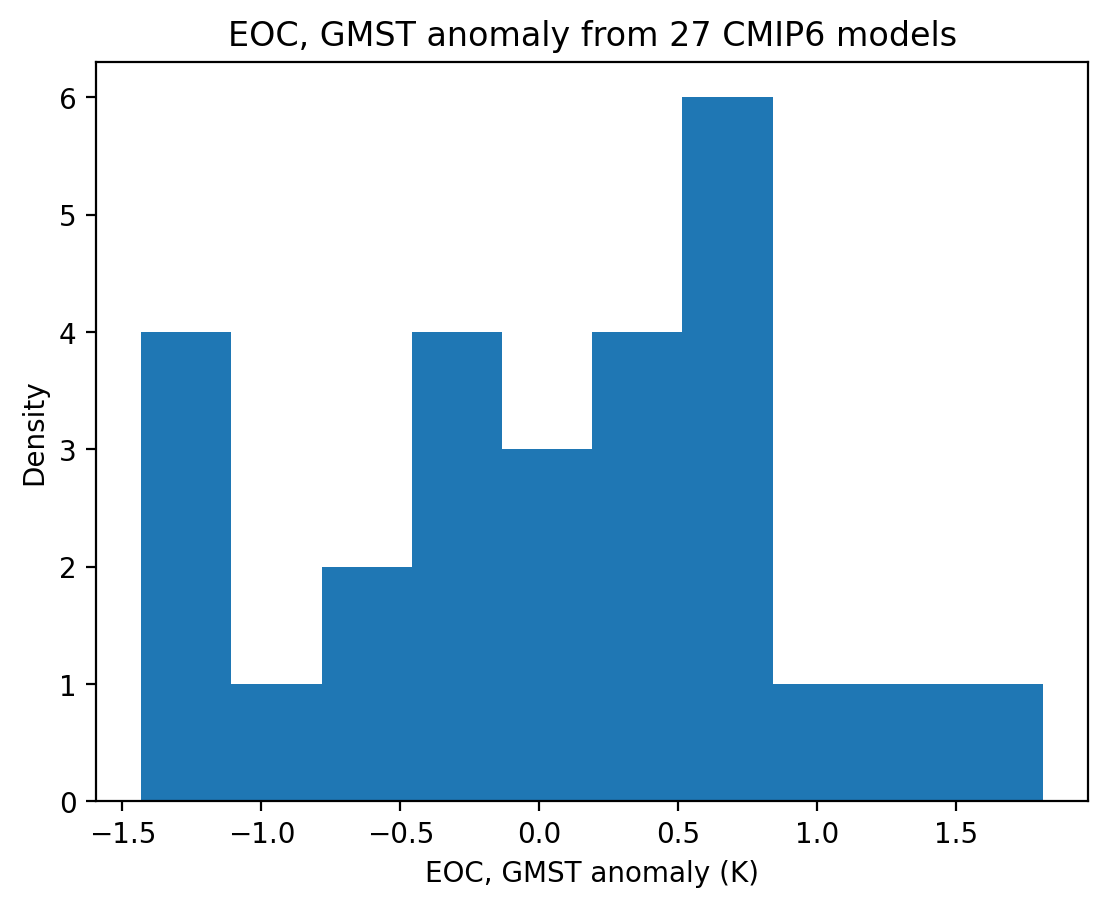

In [17]:
plt.hist(gmst_eoc - gmst_eoc.mean())
plt.xlabel('EOC, GMST anomaly (K)')
plt.ylabel('Density')
plt.title('EOC, GMST anomaly from 27 CMIP6 models')

In [18]:
print(gmst_eoc.mean().values)

291.32434890083283


In [18]:
print(gmst_eoc.std().values)

0.8283788029414559
